In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import KFold

In [2]:
data_path = 'data/sample_submission.csv'

In [3]:
df = pd.read_csv(data_path)
num_feature = df.columns.drop(['id', 'target'])
target = 'target'
df.target = df.target.clip(7,20)



# SGD
clf = SGDOneClassSVM(nu=0.55).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
df = df.iloc[~df.index.isin(lowest_quality_labels)]

df = df[df.target != 7]

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0

In [4]:
df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,2936.0,2936.000000,2936.000000,2936.000000,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,...,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,2936.000000,2936.0,2936.0
mean,0.0,8.558474,8.313348,9.209996,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.706875,0.0,0.0
std,0.0,1.287521,3.015733,6.449187,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.268716,0.0,0.0
min,0.0,7.010000,1.490000,2.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.020000,0.0,0.0
25%,0.0,7.490000,7.170000,7.400000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.725000,0.0,0.0
50%,0.0,8.390000,7.933000,8.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.370000,0.0,0.0
75%,0.0,9.110000,9.100000,8.700000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,0.0,0.0
max,0.0,20.000000,46.950000,45.900000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.725000,0.0,0.0


In [5]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# Assuming df is your DataFrame with the data and col_to_keep is a list with the columns you want to keep
col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']
training_df = df[col_to_keep]
training_ds = CustomDataset(training_df)

# Convert CustomDataset to a numpy matrix
training_data_matrix = np.array([sample.astype(np.float32) for sample in training_ds])

# Initialize the scaler, fit on the data and transform
scaler = StandardScaler()
normalized_data_matrix = scaler.fit_transform(training_data_matrix)

# Convert back to CustomDataset
normalized_df = pd.DataFrame(normalized_data_matrix, columns=col_to_keep)
normalized_training_ds = CustomDataset(normalized_df)

In [6]:
import torch as T
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(T.nn.Module):
    def __init__(self, input_dim=2, encoding_dim=32, dropout_rate=0.5):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, encoding_dim),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 10),
            nn.ReLU(),

            nn.Linear(10, 10),
            nn.ReLU(),

            nn.Linear(10, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print(device)
# Define the model
autoencoder = AutoEncoder(input_dim=4, encoding_dim=3, dropout_rate=0.0).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)  # Reduce LR every 30 epochs by 70%

cpu


In [7]:
def train(model, dataset, num_epochs=50, batch_size=32):
    dataloader = T.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_values = []
    
    best_loss = np.inf
    best_model = None

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data in dataloader:
            data = data.to(device)  # Send data to GPU
            outputs = model(data)
            loss = loss_function(outputs, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        scheduler.step()  
        average_epoch_loss = epoch_loss / len(dataloader)

        if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()
        
        loss_values.append(average_epoch_loss)
        print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')


    model.load_state_dict(best_model)
    # Plotting
    plt.plot(loss_values)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Epoch 500/500, Loss: 0.0273, Best: 0.0273

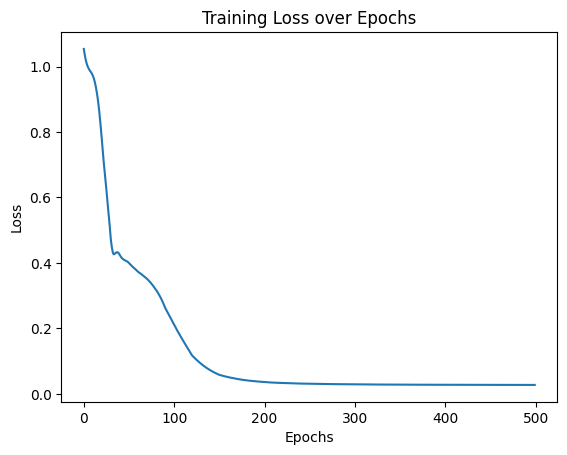

In [8]:
train(autoencoder, normalized_training_ds, num_epochs=500, batch_size=2983)
# train(autoencoder, training_ds, num_epochs=500, batch_size=2983)

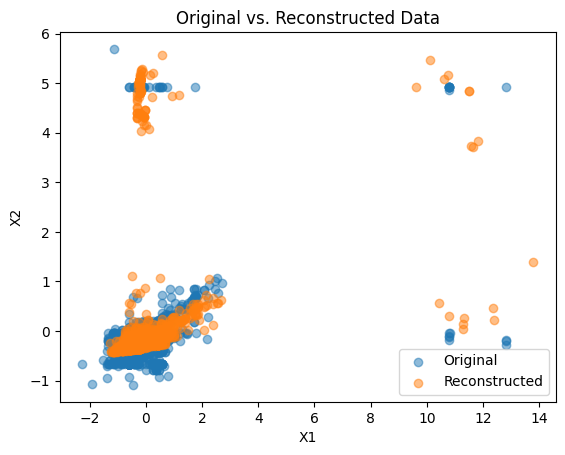

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# # Use DataLoader to handle the data transformation from Dataset to Tensor
dataloader_eval = T.utils.data.DataLoader(normalized_training_ds, batch_size=len(normalized_training_ds), shuffle=False)
# dataloader_eval = T.utils.data.DataLoader(training_ds, batch_size=len(normalized_training_ds), shuffle=False)

reconstructed_data = []
autoencoder.eval()
# Visualize the results
with torch.no_grad():
    for data in dataloader_eval:
        outputs = autoencoder(data)
        reconstructed_data.append(outputs)
        
    reconstructed_data = T.cat(reconstructed_data).numpy()
    plt.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], alpha=0.5, label='Original')
    # plt.scatter(training_df.iloc[:, 0], training_df.iloc[:, 1], alpha=0.5, label='Original')
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.5, label='Reconstructed')
    plt.title("Original vs. Reconstructed Data")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

Epoch 1000/1000, Loss: 3634.9207, Best: 3549.3823

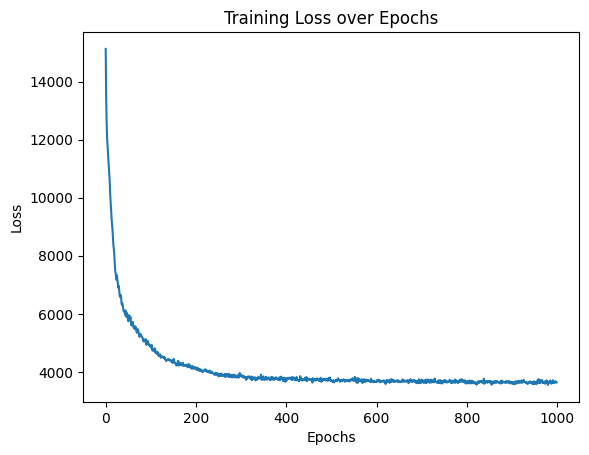

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

L = 25  # Adjust this based on your VAE architecture's latent space size

class VAE(nn.Module):
    def __init__(self, input_dim=4):
        self.input_dim = input_dim
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(self.input_dim, 25)
        self.fc2_mu = nn.Linear(25, L)
        self.fc2_logvar = nn.Linear(25, L)

        # Decoder
        self.fc3 = nn.Linear(L, 25)
        self.fc4 = nn.Linear(25, self.input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Loss function
def loss_function(recon_x, x, mu, logvar, beta=0.5):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD



# Training
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
beta = 0.5
dataloader = T.utils.data.DataLoader(normalized_training_ds, batch_size=2983, shuffle=True)
# dataloader = T.utils.data.DataLoader(training_ds, batch_size=2983, shuffle=True)
best_loss = np.inf
best_model = None
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in dataloader:
        data = data.to(device)
        model.train()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss = loss_function(recon_batch, data, mu, log_var, beta=beta)
        loss.backward()
        optimizer.step()

        epoch_loss = loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    if average_epoch_loss < best_loss:
            best_loss = average_epoch_loss
            best_model = model.state_dict()

    loss_values.append(average_epoch_loss)
    print(f'\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Best: {best_loss:.4f}', end='')

model.load_state_dict(best_model)
# Plotting
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

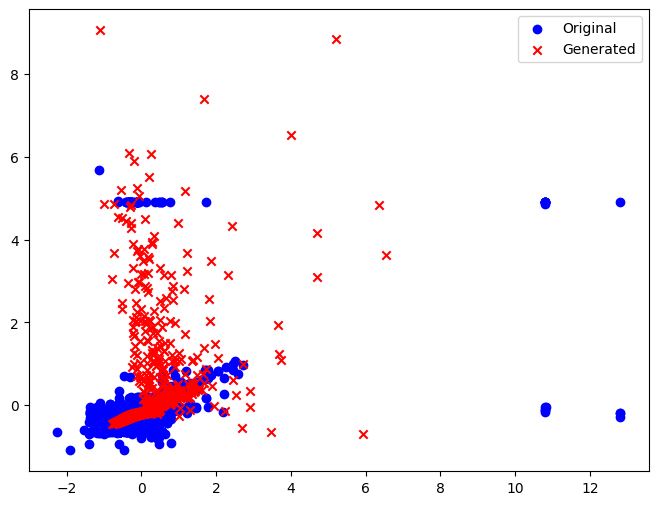

In [11]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    # Sample from a standard normal distribution
    z = torch.randn(5000, L).to(device)
    generated_samples = model.decode(z).cpu().numpy()

    
original_samples = data[:100].numpy()

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter original samples
ax.scatter(normalized_df.iloc[:, 0], normalized_df.iloc[:, 1], c='blue', marker='o', label='Original')
# ax.scatter(training_df.iloc[:, 0], training_df.iloc[:, 1], c='blue', marker='o', label='Original')
# Scatter generated samples
ax.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', marker='x', label='Generated')

ax.legend()
plt.show()


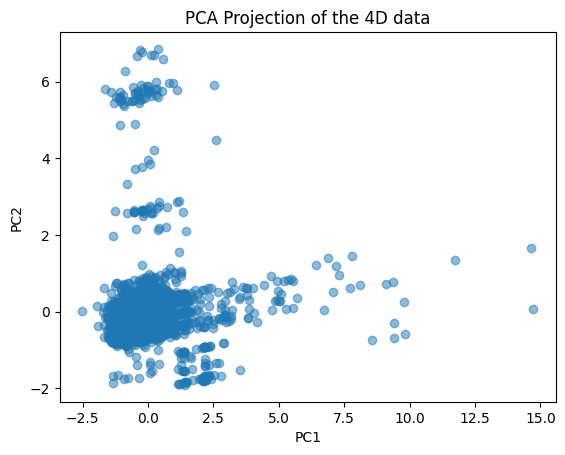

In [12]:
# Make a PCA on the normalized_df to display the 4 dimensions in 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(normalized_df)
pca_samples = pca.transform(normalized_df)
# pca.fit(training_df)
# pca_samples = pca.transform(training_df)

# Plot the 2D projection of the 4D data
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5)
plt.title("PCA Projection of the 4D data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

c:\Users\Thiba\Documents\GitHub\playground-series-s3e21\.venv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


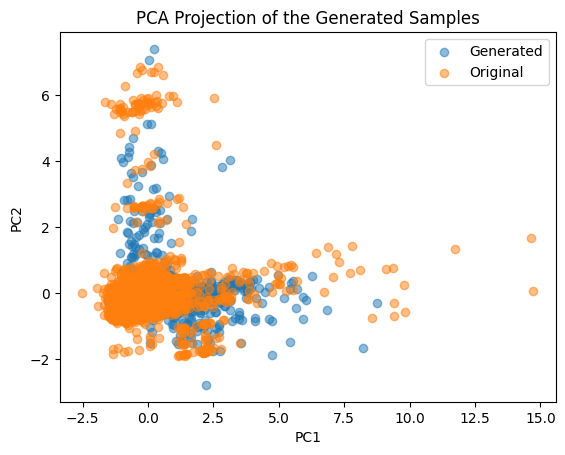

In [13]:
# With the same PCA, project the generated samples
pca_generated_samples = pca.transform(generated_samples)

# Plot the 2D projection of the generated samples
plt.scatter(pca_generated_samples[:, 0], pca_generated_samples[:, 1], alpha=0.5, label='Generated')
plt.scatter(pca_samples[:, 0], pca_samples[:, 1], alpha=0.5, label='Original')
plt.title("PCA Projection of the Generated Samples")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [14]:
# Recreate a dataframe from the generated samples, with the same column as the original dataframe
generated_df = pd.DataFrame(generated_samples, columns=['O2_1', 'O2_2', 'BOD5_5', 'target'])

# Convert the DataFrame to numpy array
generated_data_matrix = generated_df.values

# Use inverse_transform to get the original scale data
inverse_transformed_data = scaler.inverse_transform(generated_data_matrix)

# Convert back to DataFrame if needed
generated_df = pd.DataFrame(inverse_transformed_data, columns=generated_df.columns)

# Reorder the column to match the original dataframe
column_order = df.columns
generated_df = generated_df.reindex(columns=column_order)

generated_df = generated_df.fillna(0)

generated_df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,5000.0,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.000000,5000.0,5000.0
mean,0.0,8.642508,8.244901,8.524767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.366366,0.0,0.0
std,0.0,1.058407,1.185767,3.665534,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.304671,0.0,0.0
min,0.0,5.766624,4.947788,4.739254,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.682914,0.0,0.0
25%,0.0,7.857085,7.610581,7.654304,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.982999,0.0,0.0
50%,0.0,8.468051,8.119461,7.933598,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.263055,0.0,0.0
75%,0.0,9.110941,8.643806,8.151076,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.477239,0.0,0.0
max,0.0,17.643345,28.015371,67.587677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.439171,0.0,0.0


In [15]:
df.describe()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,2936.0,2936.000000,2936.000000,2936.000000,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,...,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,2936.0,2936.000000,2936.0,2936.0
mean,0.0,8.558474,8.313348,9.209996,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.706875,0.0,0.0
std,0.0,1.287521,3.015733,6.449187,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.268716,0.0,0.0
min,0.0,7.010000,1.490000,2.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.020000,0.0,0.0
25%,0.0,7.490000,7.170000,7.400000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.725000,0.0,0.0
50%,0.0,8.390000,7.933000,8.300000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.370000,0.0,0.0
75%,0.0,9.110000,9.100000,8.700000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,0.0,0.0
max,0.0,20.000000,46.950000,45.900000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.725000,0.0,0.0


In [16]:
from sklearn.model_selection import cross_val_predict
from collections import OrderedDict

def compute_rmse_contributions(X, y, n_estimators=25, max_depth=7, random_state=42):
    """
    Compute the RMSE contribution for each data point using cross-validation.
    """

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Calculate RMSE for each data point using cross-validation
    predicted_y = cross_val_predict(model, X, y, cv=5)  # You can adjust cv as needed

    # Calculate RMSE for each data point
    rmse_contributions = []
    rmse=[]
    for i in range(len(X)):
        y_true_i = y.iloc[i] if isinstance(y, pd.Series) else y[i]
        y_pred_i = predicted_y[i]
        rmse_i = np.sqrt(mean_squared_error([y_true_i], [y_pred_i]))
        rmse_contributions.append((i, rmse_i))
        rmse.append(rmse_i)
    print(np.mean(rmse))

    # Sort RMSE contributions in decreasing order
    sorted_rmse_contributions = OrderedDict(sorted(rmse_contributions, key=lambda x: x[1], reverse=True))

    return sorted_rmse_contributions

In [17]:
X = df.drop(columns=['target'])
y = df['target']

sorted_rmse_contributions = compute_rmse_contributions(X, y)

0.6703509082397948


In [18]:
X = generated_df.drop(columns=['target'])
y = generated_df['target']

sorted_rmse_contributions_generated = compute_rmse_contributions(X, y)

0.07008770824621245


In [19]:
worst_indexes = list(sorted_rmse_contributions.keys())[:50]

print("Top 100 Indexes with High RMSE:")
for index in worst_indexes:
    rmse = sorted_rmse_contributions[index]
    print(f"Index {index}: RMSE = {rmse}")

Top 100 Indexes with High RMSE:
Index 257: RMSE = 11.361872380952379
Index 1569: RMSE = 10.705173333333336
Index 1078: RMSE = 7.234400000000001
Index 2005: RMSE = 6.1237681792717105
Index 1323: RMSE = 5.7666492002734095
Index 1276: RMSE = 5.417944425770305
Index 653: RMSE = 5.104121168504378
Index 1933: RMSE = 4.968059855256611
Index 326: RMSE = 4.895652237920901
Index 1739: RMSE = 4.782136782540501
Index 1488: RMSE = 4.77721615349674
Index 989: RMSE = 4.73295873485209
Index 974: RMSE = 4.032366666666663
Index 1601: RMSE = 3.852106870335021
Index 440: RMSE = 3.776019999999999
Index 1726: RMSE = 3.647625004021016
Index 2126: RMSE = 3.63828257143874
Index 133: RMSE = 3.5241238295056636
Index 2507: RMSE = 3.5141319578271197
Index 429: RMSE = 3.4919038033936296
Index 1039: RMSE = 3.431417409822812
Index 1: RMSE = 3.4001
Index 1007: RMSE = 3.3378964865991207
Index 2694: RMSE = 3.212934291530133
Index 376: RMSE = 3.0327690952380895
Index 238: RMSE = 2.9391327272727246
Index 386: RMSE = 2.930

In [20]:
best_indexes = list(sorted_rmse_contributions.keys())[-50:][::-1]

print("Top 100 Indexes with Low RMSE:")
for index in best_indexes:
    rmse = sorted_rmse_contributions[index]
    print(f"Index {index}: RMSE = {rmse}")

Top 100 Indexes with Low RMSE:
Index 118: RMSE = 0.00016192184465957382
Index 2472: RMSE = 0.002039251638658257
Index 37: RMSE = 0.002467358001423392
Index 1435: RMSE = 0.00250744121825619
Index 1376: RMSE = 0.003073419864545457
Index 681: RMSE = 0.0031768109342600326
Index 921: RMSE = 0.0040775752654633735
Index 1129: RMSE = 0.004143236167120534
Index 2226: RMSE = 0.004674514673432384
Index 1684: RMSE = 0.006016156542294482
Index 959: RMSE = 0.006806834187988997
Index 1732: RMSE = 0.007105450022672599
Index 2092: RMSE = 0.007162589280369502
Index 2020: RMSE = 0.007837342098039102
Index 2374: RMSE = 0.00846083824467847
Index 194: RMSE = 0.008469266356383898
Index 381: RMSE = 0.008912832822320915
Index 1280: RMSE = 0.009317903325078092
Index 353: RMSE = 0.009838078155340213
Index 745: RMSE = 0.009898240172615758
Index 1146: RMSE = 0.009910011563409427
Index 1202: RMSE = 0.010273336657659726
Index 904: RMSE = 0.01032522856868745
Index 2119: RMSE = 0.010693734698694612
Index 2680: RMSE = 

In [21]:
to_reinject = 3500-df.shape[0]

In [22]:
worst_indexes_generated = list(sorted_rmse_contributions.keys())[:to_reinject]

In [23]:
# We will add these samples to the generated samples
df_to_add = df.iloc[worst_indexes_generated]

# Add the generated samples to the original dataframe
# df = df.append(df_to_add)
final_df = pd.concat([df, df_to_add], ignore_index=True)


In [24]:
final_df.shape

(3500, 37)

In [25]:
final_df.to_csv('submission.csv', index=False)